In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from funciones import SOM, Oja
from collections import defaultdict
#from minisom import MiniSom # for comparison l42
from sklearn.decomposition import PCA

### Load and format data

In [2]:
# Load dataset with specified data types
dtypes = {'Country': 'str', 
          'Area': 'int64', 
          'GDP': 'int64', 
          'Inflation': 'float64', 
          'Life.expect': 'float64', 
          'Military': 'float64', 
          'Pop.growth': 'float64', 
          'Unemployment': 'float64'}

df = pd.read_csv('europe.csv', dtype=dtypes)

# Separate country names since it's not numerical
country_names = df['Country']
df_numeric = df.drop('Country', axis=1)

# Normalize numerical data
df_numeric = (df_numeric - df_numeric.mean()) / df_numeric.std()

# 1.1 Red de Kohonen

### Self-Organizing Map (SOM) / Kohonen map

In [3]:
# Define SOM parameters
x = 5  # Width of map
y = 5  # Height of map
input_len = df_numeric.shape[1]  # Number of features in data
sigma = 1.0 # Neighbourhood radius
learning_rate = 0.5

# Create SOM
som = SOM(x, y, input_len, sigma, learning_rate) # create SOM
som.random_weights_init(df_numeric.values) # initial random weights

# Train SOM
iterations = 10000
som.train_random(df_numeric.values, iterations)

### Unified Distance Matrix  (U-Matrix)

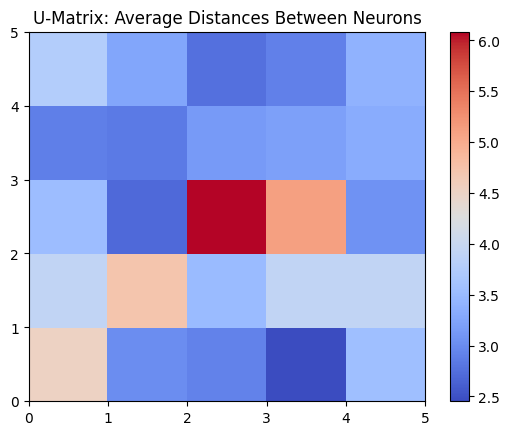

In [4]:
# Plot U-Matrix of the SOM
plt.pcolor(som.distance_map().T, cmap='coolwarm') # https://matplotlib.org/stable/gallery/color/colormap_reference.html
plt.colorbar()
plt.title('U-Matrix: Average Distances Between Neurons')
plt.show()

### Winning neuron. Elements assigned to each neuron

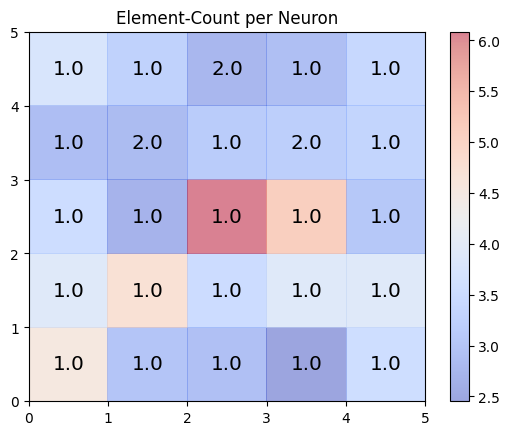

In [5]:
# Calculate element counts for each neuron
neuron_counts = defaultdict(int)
winning_countries = defaultdict(list)

for i, sample in enumerate(df_numeric.values):
    winning_neuron = som.winner(sample)
    neuron_counts[winning_neuron] += 1
    winning_countries[winning_neuron].append(country_names.iloc[i])

# Reshape counts into grid, handling potential dead neurons
counts_grid = np.zeros((x, y))  # Initialize to zeros
for coordinates, count in neuron_counts.items():
    x_coord, y_coord = coordinates
    counts_grid[y_coord][x_coord] = count

# Initialize plot
fig, ax = plt.subplots()

# Plot the U-Matrix/SOM grid (to put count on)
plt.pcolor(som.distance_map().T, cmap='coolwarm', alpha=0.5)

# Overlay count labels on neurons
for x in range(som.get_weights().shape[0]):
    for y in range(som.get_weights().shape[1]):
        ax.text(x + 0.5, y + 0.5, str(counts_grid[y][x]),
                ha='center', va='center', size='x-large')

ax.set_title('Element-Count per Neuron')
plt.colorbar()
plt.show()

### Categorization of countries

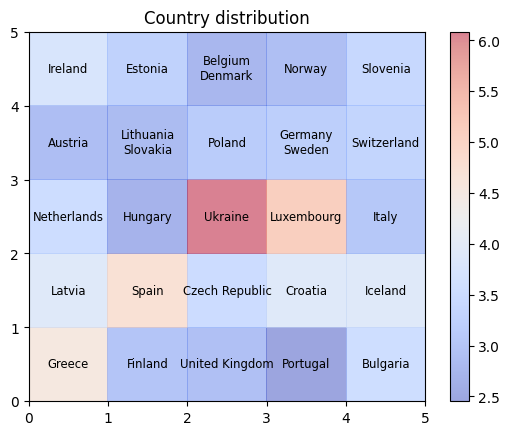

In [6]:
# Initialize plot
fig, ax = plt.subplots()

# Plot the U-Matrix/SOM grid (to put countries on)
plt.pcolor(som.distance_map().T, cmap='coolwarm', alpha=0.5)

# Overlay countries on each neuron
for x in range(som.get_weights().shape[0]):
    for y in range(som.get_weights().shape[1]):
        countries = winning_countries.get((x, y), [])
        if countries:
            country_text = "\n".join(countries)  # Join with newlines
            ax.text(x + 0.5, y + 0.5, country_text, ha='center', va='center', size='small', wrap=True)
ax.set_title('Country distribution')
plt.colorbar()
plt.show()

# Ejercicio 1.2 - Modelo de Oja

### Modelo de Oja

In [7]:
# Oja's Rule
oja_input_len = df_numeric.shape[1]
oja_learning_rate = 0.01
iterations = 10000

oja = Oja(oja_input_len, oja_learning_rate)
oja.train(df_numeric.values, iterations)

# Get the first principal component from Oja's rule
oja_weights = oja.get_weights()

### PC1 coefficients of attributes - print

In [8]:
# Create a dictionary to associate features with coefficients
feature_names = df_numeric.columns
feature_coef_dict = dict(zip(feature_names, oja_weights))

# Sort the dictionary by coefficient values high to low
sorted_features = sorted(feature_coef_dict.items(), key=lambda item: item[1], reverse=True)

# Print PC1 coefficients along with their respective features in sorted order
print("\nPC1 coefficients of attributes:")
for feature, coefficient in sorted_features:
    print(f"{feature}: {coefficient:.2f}")


PC1 coefficients of attributes:
Life.expect: 0.50
GDP: 0.49
Pop.growth: 0.46
Military: -0.13
Area: -0.20
Unemployment: -0.23
Inflation: -0.48


### PC1 score of countries - print

In [9]:
# Project data onto the first principal component
pc1_scores = df_numeric.dot(oja_weights)

# Create a DataFrame to associate country names with PC1 scores
result_df = pd.DataFrame({'Country': country_names, 'PC1': pc1_scores})
result_df_sorted = result_df.sort_values(by='PC1', ascending=False) # sort results high to low PC1 score

# Print unsorted country PC1 score
#print("\nPC1 score of countries:")
#print(result_df)

# Print sorted results of PC1 score
print("\nPC1 value of countries:")
for index, row in result_df_sorted.iterrows():
    print(f"{row['Country']}: {row['PC1']:.2f}")


PC1 value of countries:
Luxembourg: 3.34
Switzerland: 3.32
Norway: 2.06
Netherlands: 1.87
Ireland: 1.81
Iceland: 1.41
Austria: 1.00
Denmark: 0.96
Italy: 0.81
Sweden: 0.74
Belgium: 0.69
Germany: 0.52
United Kingdom: 0.29
Czech Republic: 0.24
Finland: 0.15
Slovenia: 0.11
Spain: 0.09
Portugal: -0.42
Greece: -0.70
Slovakia: -0.76
Croatia: -1.02
Hungary: -1.35
Lithuania: -1.49
Poland: -1.51
Latvia: -2.28
Estonia: -2.41
Bulgaria: -2.49
Ukraine: -4.97


### PCA with package to compare results

In [10]:
# Perform PCA using scikit-learn
pca = PCA(n_components=1)
pca.fit(df_numeric)

# Get the first principal component
first_pc = pca.components_[0]

# Create a dictionary to associate features with coefficients
feature_coef_dict = dict(zip(df_numeric.columns, first_pc))

# Sort the dictionary by coefficient values in descending order
sorted_features = sorted(feature_coef_dict.items(), key=lambda item: item[1], reverse=True)

# Print PC1 coefficients along with their respective features in sorted order
print("\nPC1 coefficients of attributes (with library):")
for feature, coefficient in sorted_features:
    print(f"{feature}: {coefficient:.2f}")


PC1 coefficients of attributes (with library):
Inflation: 0.41
Unemployment: 0.27
Military: 0.19
Area: 0.12
Pop.growth: -0.48
Life.expect: -0.48
GDP: -0.50


In [11]:
# Project the data onto the principal component
pc1_scores = pca.transform(df_numeric)

# Combine countries and their PC1 scores into a DataFrame
result_df = pd.DataFrame({'Country': country_names, 'PC1': pc1_scores.squeeze()})  # squeeze() converts to 1D array

# Sort by PC1 in descending order
result_df_sorted = result_df.sort_values(by='PC1', ascending=False)

# Print the sorted PC1 scores for each country
print("\nPC1 value of countries (with library):")
for index, row in result_df_sorted.iterrows():
    print(f"{row['Country']}: {row['PC1']:.2f}")


PC1 value of countries (with library):
Ukraine: 4.50
Bulgaria: 2.56
Estonia: 2.44
Latvia: 2.26
Lithuania: 1.50
Poland: 1.45
Hungary: 1.37
Croatia: 1.25
Greece: 0.98
Slovakia: 0.77
Portugal: 0.52
Slovenia: 0.07
Spain: -0.16
Czech Republic: -0.16
Finland: -0.21
United Kingdom: -0.33
Germany: -0.58
Belgium: -0.67
Italy: -0.84
Sweden: -0.87
Denmark: -0.94
Austria: -1.06
Iceland: -1.56
Ireland: -1.78
Netherlands: -1.81
Norway: -2.07
Switzerland: -3.22
Luxembourg: -3.42
